<a href="https://www.kaggle.com/code/radunicolaesiderias/spaceshipsolutionoptimisation?scriptVersionId=121873648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


CryoSleep: 0.11261608366144049
Spa: 0.07192215102657151
RoomService: 0.07073772764695652
VRDeck: 0.06802631948252214
ShoppingMall: 0.04450264125350456
FoodCourt: 0.040924734292051124
HomePlanet: 0.028086644655507476
Name: 0.026445756878186844
Cabin: 0.02584947469680743
GroupId: 0.022228053736440767
PassengerId: 0.018866006721909745
NumberWithinGroup: 0.012631770007575094
Age: 0.011092260668509324
Destination: 0.007480001080701015
VIP: 0.0


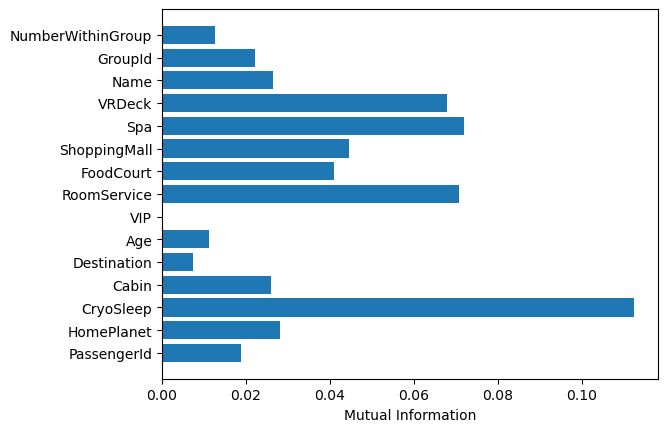

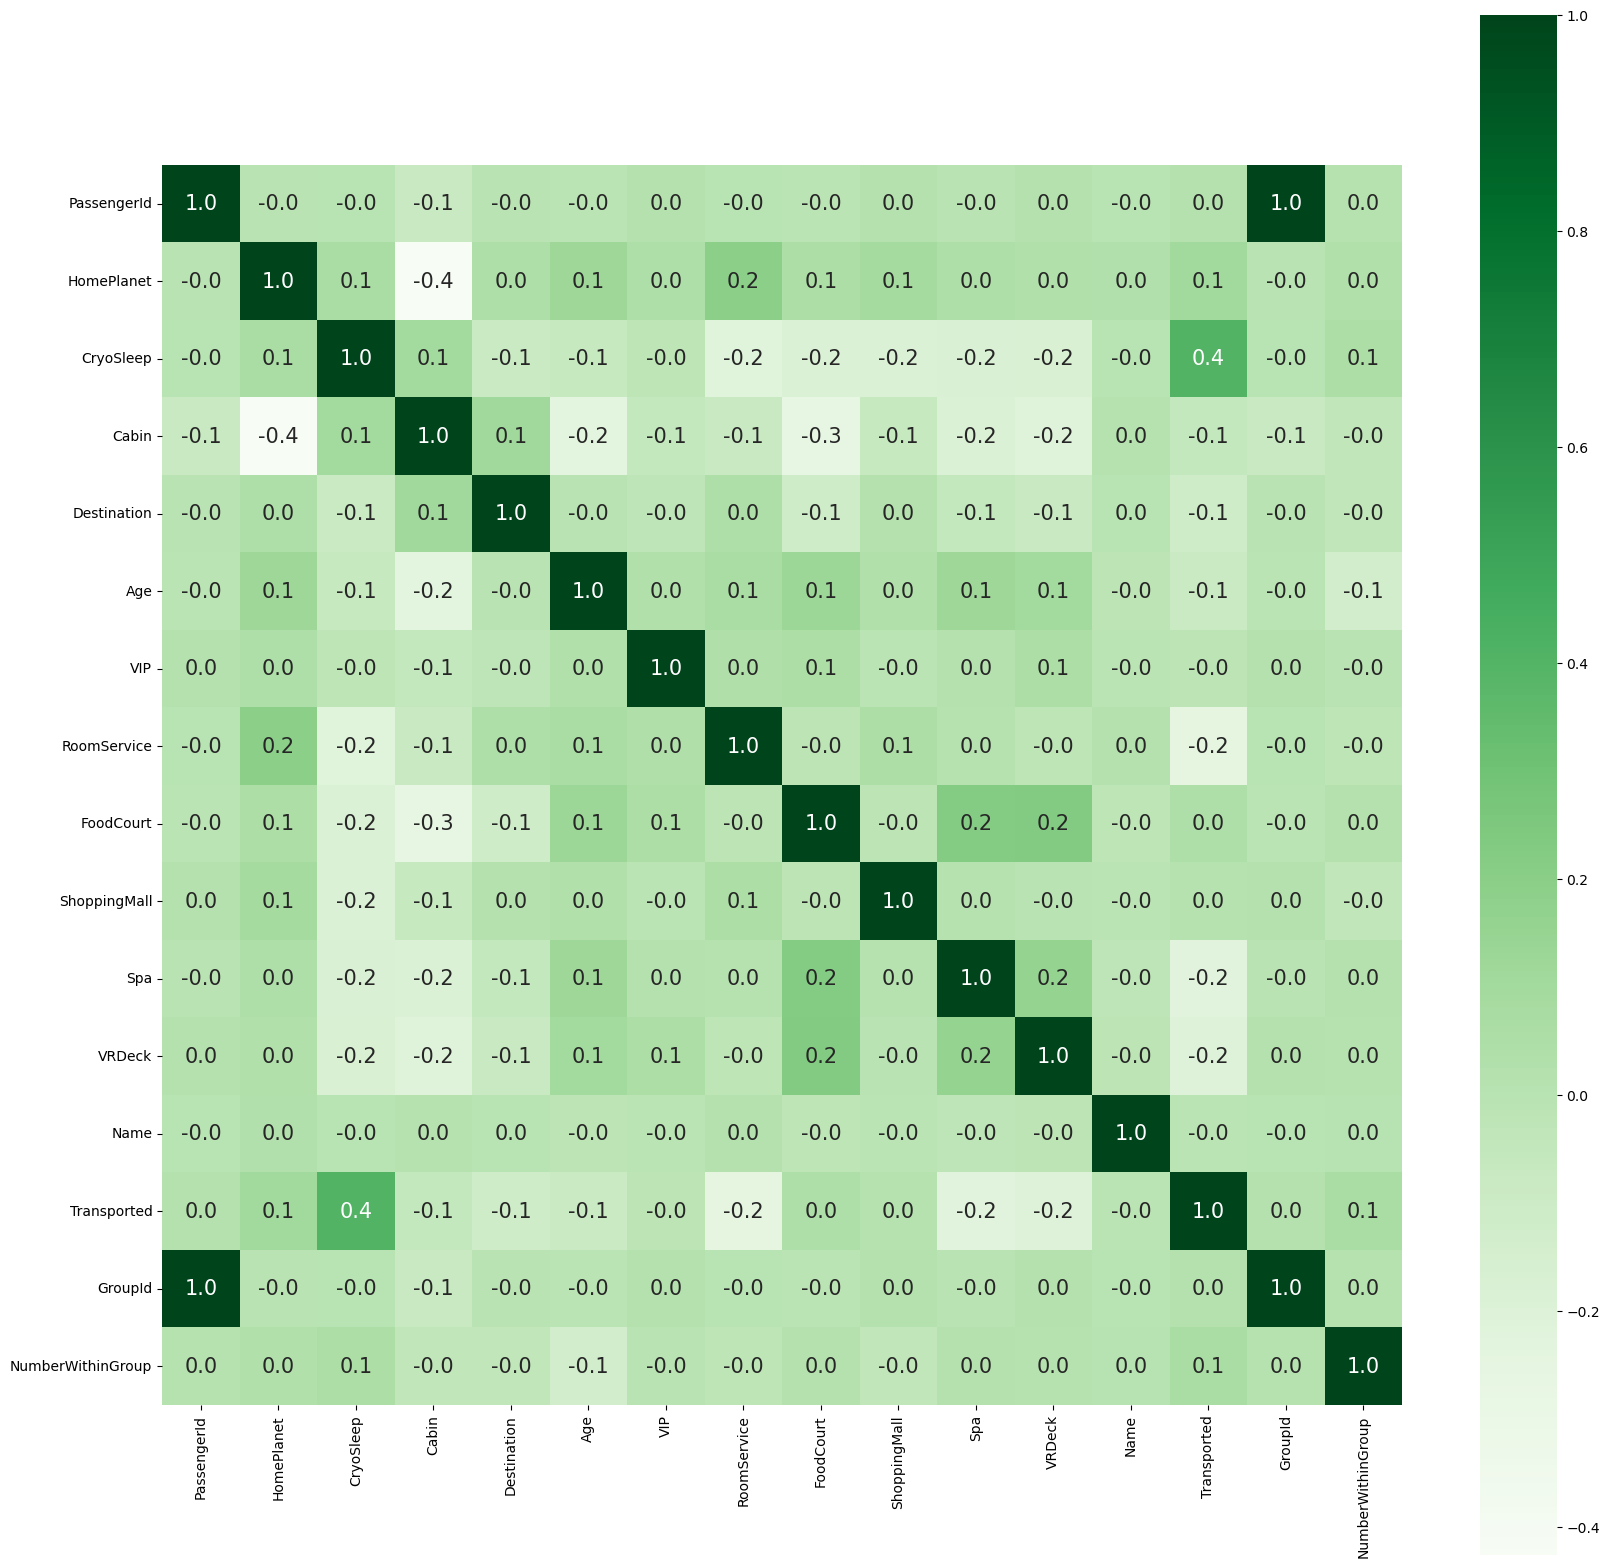

Feature: 0, Score: 0.01230
Feature: 1, Score: 0.06647
Feature: 2, Score: 0.35148
Feature: 3, Score: 0.03392
Feature: 4, Score: 0.03192
Feature: 5, Score: 0.15451
Feature: 6, Score: 0.07467
Feature: 7, Score: 0.04542
Feature: 8, Score: 0.12308
Feature: 9, Score: 0.10091
Feature: 10, Score: 0.00532




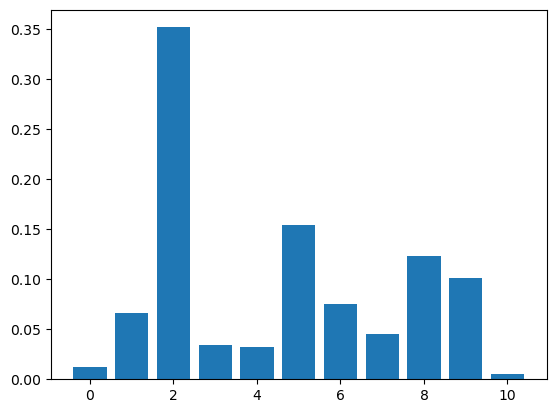

Your submission was successfully saved!


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
import seaborn as sns


#Load data
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")



#Feature Engineering - optimisation
#PassengerId -> GroupId, NumberWithinGroup
train_data[["GroupId", "NumberWithinGroup"]] = (
    train_data["PassengerId"]
    .str
    .split("_", n=1, expand=True)
)
test_data[["GroupId", "NumberWithinGroup"]] = (
    test_data["PassengerId"]
    .str
    .split("_", n=1, expand=True)
)



#Encoding to Int32
test_data_copy = test_data.copy()

label_encoder = LabelEncoder()

for col in train_data.columns:
    if train_data[col].dtype == 'object':
        train_data[col] = label_encoder.fit_transform(train_data[col])

for col in test_data.columns:
    if test_data[col].dtype == 'object':
        test_data[col] = label_encoder.fit_transform(test_data[col])

  

#Data imputation - optimisation
imp_mean = SimpleImputer(strategy='most_frequent')
imp_mean.fit(train_data)
imputed_train_data = pd.DataFrame(imp_mean.transform(train_data),columns=train_data.columns)

imp_mean.fit(test_data)
imputed_test_data = pd.DataFrame(imp_mean.transform(test_data),columns=test_data.columns)



#Plot mutual info between features
X_mtl = imputed_train_data.drop("Transported", axis=1) 
y_mtl = imputed_train_data["Transported"].astype(bool)
mi_scores = mutual_info_classif(X_mtl, y_mtl, discrete_features='auto', random_state=42)
mi_dict = dict(zip(X_mtl.columns, mi_scores))
sorted_mi_dict = dict(sorted(mi_dict.items(), key=lambda x: x[1], reverse=True))
for feature, mi_score in sorted_mi_dict.items():
    print(f'{feature}: {mi_score}')

fig, ax = pyplot.subplots()
ax.barh(range(len(mi_scores)), mi_scores)
ax.set_yticks(range(len(mi_scores)))
ax.set_yticklabels(X_mtl.columns)
ax.set_xlabel('Mutual Information')
pyplot.show()



# Plotting the heatmap of correlation between features
corr = train_data.corr()
pyplot.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')
pyplot.show()



#Devide data in features and target
y = imputed_train_data["Transported"].astype(bool)
features = ["GroupId", "HomePlanet", "CryoSleep", "Cabin", "Age",
       "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name"]
X = imputed_train_data[features]
X_test = imputed_test_data[features]



#Train model
model = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

grid_obj = GridSearchCV(model, parameters)
grid_obj = grid_obj.fit(X, y)
model_optim = grid_obj.best_estimator_


model_optim.fit(X,y)
predictions = model_optim.predict(X_test)



#Plot importance of trained features 
importance = model_optim.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('\n')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()



#Output
output = pd.DataFrame({'PassengerId': test_data_copy.PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")